In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext import vocab
import pandas as pd
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import re
# Download NLTK tokenizer data
nltk.download('punkt')

# Determine device (GPU if available, otherwise CPU)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DEVICE

device(type='cuda')

In [3]:
filepath = "/kaggle/input/hindi-data1/shuffled_train.xlsx"



# Read the Excel file using pandas
data = pd.read_excel(filepath)

# Display the first few rows of the DataFrame
data.head()


,S.NO,author,date,verified,image_url,title_hindi,content_hindi,rating
0,1914,Sushma Bhalotia,Reviewed in India on 19 March 2024,Verified Purchase,NaN,पहले दिन काम नहीं हुआ,"लोहा काम नहीं कर रहा है, गर्म नहीं हो रहा है",2
1,25,Nandakumar,Reviewed in India on 10 April 2024,Verified Purchase,NaN,चार्ज बहुत जल्दी खत्म हो जाता है,मुझे डिज़ाइन पसंद है और कोई शोर नहीं है। लेकिन...,2
2,779,Anand Vishnu Prakash,Reviewed in India on 16 October 2023,Verified Purchase,NaN,उत्पाद ने दो सप्ताह में काम करना बंद कर दिया,मैं किसी को भी इस ब्रश की अनुशंसा नहीं करूंगा।...,2
3,2982,Hara kumar,Reviewed in India on 9 April 2024,Verified Purchase,NaN,उतरते समय चार्ज करना,"उत्पाद अच्छा था, चार्जिंग बहुत खराब थी, हमने फ...",3
4,1839,Ashish A.,Reviewed in India on 10 January 2024,Verified Purchase,NaN,ख़राब गुणवत्ता वाला माउस,इस बार विक्रेता द्वारा आपूर्ति किये गये चूहों ...,2


In [4]:
filepath_test = "/kaggle/input/hindi-data1/test.xlsx"



# Read the Excel file using pandas
data_test = pd.read_excel(filepath_test)

# Display the first few rows of the DataFrame
data_test.head()

,S.NO,author,date,verified,image_url,title_hindi,content_hindi,rating
0,2046,Topen,Reviewed in India on 20 December 2023,Verified Purchase,https://m.media-amazon.com/images/I/61bhDatJqp...,स्क्रॉल बटन ने 14 दिनों के बाद काम करना बंद कर...,खरीदारी के मात्र 14 दिन बाद स्क्रॉलिंग बटन ने ...,1
1,4015,Narresh,Reviewed in India on 4 March 2024,Verified Purchase,NaN,खराब क्वालिटी,इसका कोई मूल्य नहीं है. अच्छे उत्पाद ही खरीदें...,1
2,280,Rohan Sahu,Reviewed in India on 28 January 2024,Verified Purchase,https://m.media-amazon.com/images/I/61D2R4g99J...,मैं आपको तुरंत चेतावनी देता हूं कि इस उत्पाद क...,मीडिया लोड नहीं किया जा सका. कई ग्राहकों को क्...,1
3,310,Anil,Reviewed in India on 13 April 2024,Verified Purchase,NaN,पैसे की बर्बादी मत खरीदो ð¯,पैसे की बर्बादी मत खरीदो ð¯,1
4,1745,Amazon Customer,Reviewed in India on 12 April 2024,Verified Purchase,NaN,4 महीने से काम भी नहीं,4 महीने बाद भी ब्लूटूथ काम नहीं कर रहा है,1


In [5]:
print(data.shape)

(3527, 8)


In [6]:
print(data_test.shape)

(884, 8)


In [7]:
def plot_rating(ratings):
    # Count occurrences of each rating (1 to 5)
    rating_counts = ratings.value_counts().sort_index()

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plotting the Bar Graph on the first subplot (ax1)
    ax1.bar(rating_counts.index, rating_counts.values, color='skyblue',edgecolor='black', width=0.3)
    ax1.set_title('Count of Ratings (1 to 5)')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.set_xticks(rating_counts.index)  # Set x-axis ticks to ratings (1 to 5)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Plotting the Pie Chart on the second subplot (ax2)
    ax2.pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'gold', 'lightgreen', 'plum'])
    ax2.set_title('Distribution of Ratings (1 to 5)')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [8]:

rating_map = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3}
data['rating'] = data['rating'].map(lambda x: rating_map[x] if x in rating_map else 3)

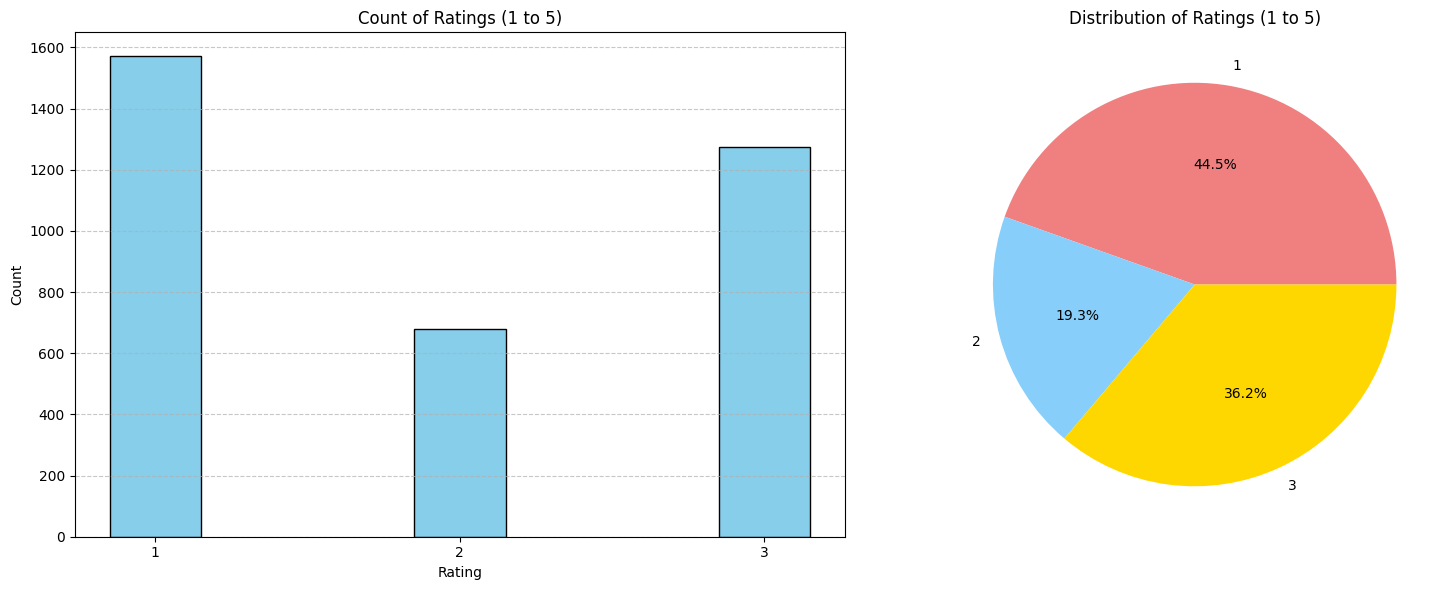

In [9]:
ratings = data['rating']
plot_rating(ratings)

In [10]:
rating_map = {1: 1, 2: 1, 3: 2, 4: 3, 5: 3}
data_test['rating'] = data_test['rating'].map(lambda x: rating_map[x] if x in rating_map else 3)

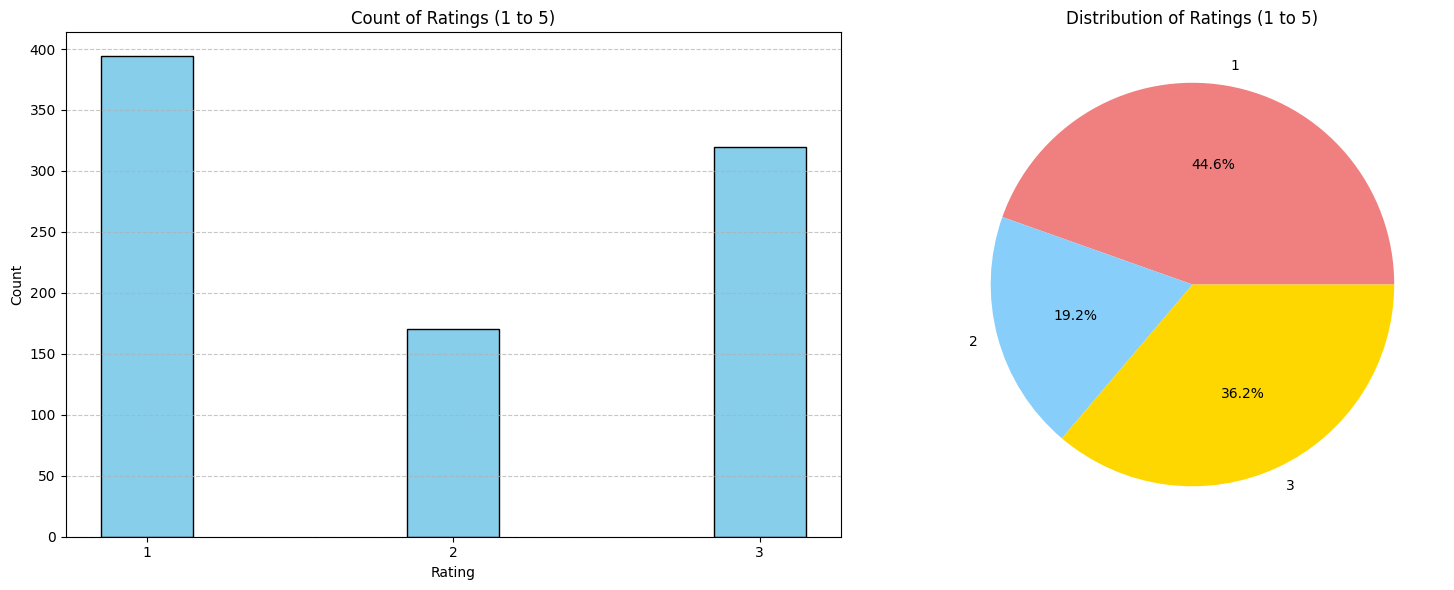

In [11]:
ratings_test = data_test['rating']
plot_rating(ratings_test)

In [15]:
stopwords_file_path = '/kaggle/input/stopwords/stopwords-hi.txt'


with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stopwords_list = file.read().split()

# Function to preprocess text
def remove_extra_space(text):
    text = re.sub(r'\s+', ' ', text)

    return text

# Load your dataset

# Merge 'title_hindi' and 'content_hindi' into a single column 'merged_text'


In [16]:
data['merged_text'] = data['title_hindi'] + ' ' + data['content_hindi']

In [17]:
data_test['merged_text'] = data_test['title_hindi'] + ' ' + data_test['content_hindi']

In [20]:
data['cleaned_merged_text'] = data['merged_text'].apply(remove_extra_space)

In [21]:
data_test['cleaned_merged_text'] = data_test['merged_text'].apply(remove_extra_space)

In [32]:
print(data['cleaned_merged_text'].head())

0    पहले दिन काम नहीं हुआ लोहा काम नहीं कर रहा है,...
1    चार्ज बहुत जल्दी खत्म हो जाता है मुझे डिज़ाइन ...
2    उत्पाद ने दो सप्ताह में काम करना बंद कर दिया म...
3    उतरते समय चार्ज करना उत्पाद अच्छा था, चार्जिंग...
4    ख़राब गुणवत्ता वाला माउस इस बार विक्रेता द्वार...
Name: cleaned_merged_text, dtype: object


In [33]:
print(data_test['cleaned_merged_text'].head())

0    स्क्रॉल बटन ने 14 दिनों के बाद काम करना बंद कर...
1    खराब क्वालिटी इसका कोई मूल्य नहीं है. अच्छे उत...
2    मैं आपको तुरंत चेतावनी देता हूं कि इस उत्पाद क...
3    पैसे की बर्बादी मत खरीदो ð¯ पैसे की बर्बादी मत...
4    4 महीने से काम भी नहीं 4 महीने बाद भी ब्लूटूथ ...
Name: cleaned_merged_text, dtype: object


In [34]:
def plot_sentence_length_histogram(sentences):
    # Tokenize each sentence into words and count the number of words in each sentence
    word_counts = sentences.apply(lambda x: len(x.split()))

    # Calculate summary statistics
    max_length = word_counts.max()
    min_length = word_counts.min()
    avg_length = word_counts.mean()

    # Create a histogram of word counts
    plt.figure(figsize=(10, 6))
    plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')

    # Add labels and title
    plt.title('Distribution of Sentence Lengths (Number of Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    # Display summary statistics on the plot
    plt.text(0.8, 0.9, f'Max Length: {max_length}', transform=plt.gca().transAxes)
    plt.text(0.8, 0.85, f'Min Length: {min_length}', transform=plt.gca().transAxes)
    plt.text(0.8, 0.8, f'Avg Length: {avg_length:.2f}', transform=plt.gca().transAxes)

    # Show the plot
    plt.show()

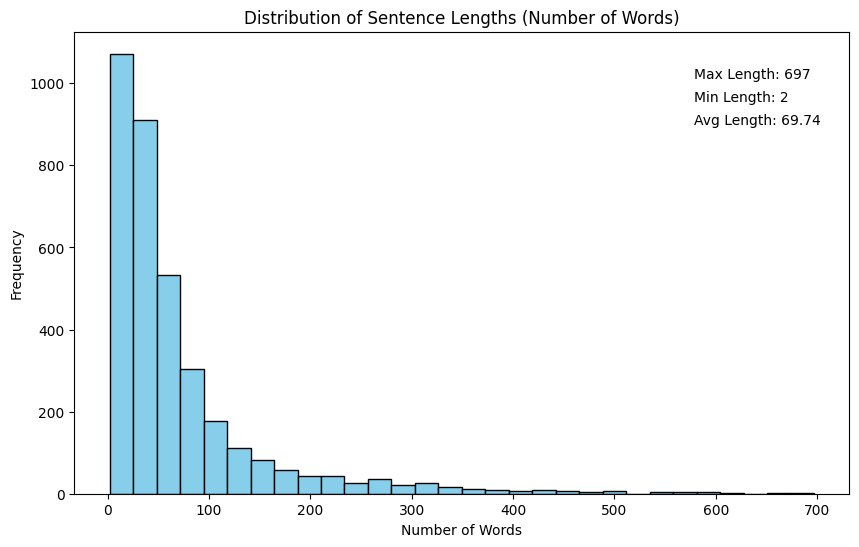

In [35]:
sentences = data['cleaned_merged_text']
plot_sentence_length_histogram(sentences)

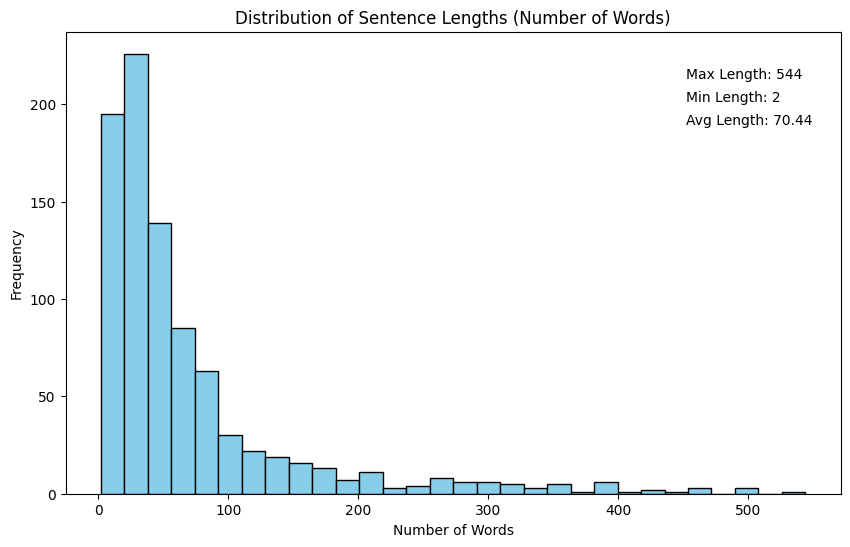

In [36]:
sentences_test = data_test['cleaned_merged_text']
plot_sentence_length_histogram(sentences_test)

In [37]:
class ProcessYelp():
  def __init__(self, cleaned_df, min_freq):
    # self.filepath = filepath
    self.min_freq = min_freq

    df = cleaned_df
    total_words = []
    for i in tqdm(range(len(df)), desc="Vocabulary"):
        line = df['cleaned_merged_text'][i]
        total_words += [[word.lower()] for word in word_tokenize(line)]

    self.vocab = vocab.build_vocab_from_iterator(total_words,
                                                  min_freq = min_freq,
                                                  specials = ['<UNK>', '<PAD>'])
    self.vocab.set_default_index(self.vocab['<UNK>'])




In [38]:
processed_data = ProcessYelp(data, 3)
vocab_tokens = processed_data.vocab.get_itos()

Vocabulary: 100%|██████████| 3527/3527 [00:02<00:00, 1229.88it/s]


In [39]:
len(vocab_tokens)

4437

In [40]:
class LabelData(Dataset):
    def __init__(self, vocab, cleaned_df, max_length=35):
        self.vocab = vocab
        self.data = cleaned_df
        self.max_length = max_length

    def __getitem__(self, index):
        description = self.data.loc[index, 'cleaned_merged_text']
        label = self.data.loc[index, 'rating']

        # Tokenize the description
        tokens = word_tokenize(description.lower())
        
        # Truncate or pad tokens to max_length
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
        else:
            tokens += ['<PAD>'] * (self.max_length - len(tokens))
        
        token_indices = [self.vocab[token.lower()] if token.lower() in self.vocab else self.vocab['<PAD>'] for token in tokens]

        return torch.tensor(token_indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.data)

In [41]:
label_train_dataset = LabelData(processed_data.vocab,data,35)

In [42]:
label_test_dataset = LabelData(processed_data.vocab,data_test,35)

In [43]:
# index = 2  # Choose the index of the data instance you want to access
# tokens, label = label_train_dataset[index]
# tokens_list = tokens.tolist()  # Convert tensor to list
# label_value = label.item()

In [44]:
vocab_size = len(processed_data.vocab)  # Assuming you have defined 'vocab' somewhere
embedding_size = 35
hidden_size = 128
output_size = 3
batch_size = 1
learning_rate = 0.001
num_epochs = 10

In [45]:
train_dataloader = DataLoader(label_train_dataset, batch_size=1, shuffle=False)

In [46]:
test_dataloader = DataLoader(label_test_dataset, batch_size=1, shuffle=False)

In [59]:


class FFNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout_prob=0.5):
        super(FFNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = embedded.mean(dim=1)
        out = self.fc1(pooled)
        out = self.relu(out)
        out = self.dropout(out)  # Adding dropout layer
        out = self.fc2(out)
        return out

In [77]:
model = FFNNClassifier(vocab_size, embedding_size, hidden_size, output_size).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [78]:
def train_model(model, train_dataloader, criterion, optimizer, epochs, device):
    train_losses = []

    # Training loop
    for epoch in tqdm(range(15)):
        total_loss_train = 0

        model.train()  # Set the model to training mode
        for i, (sentence, label) in enumerate(train_dataloader):
            sentence, label = sentence.to(device), label.to(device)
            label -= 1  # Adjust labels (assuming they are 1-based)

            optimizer.zero_grad()
            outputs = model(sentence)
#             print(label)
#             print()
#             print(outputs)
#             exit(1)
            # Calculate loss
            batch_loss = criterion(outputs, label)
            total_loss_train += batch_loss.item()

            # Backpropagation
            batch_loss.backward()
            optimizer.step()

        # Calculate average training loss for the epoch
        avg_train_loss = total_loss_train / len(train_dataloader)
        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")

    # Plot the training loss graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

  7%|▋         | 1/15 [00:08<01:59,  8.56s/it]

Epoch 1, Train Loss: 0.9237200446019035


 13%|█▎        | 2/15 [00:17<01:52,  8.66s/it]

Epoch 2, Train Loss: 0.7231931588505701


 20%|██        | 3/15 [00:25<01:43,  8.63s/it]

Epoch 3, Train Loss: 0.6099444220253506


 27%|██▋       | 4/15 [00:34<01:34,  8.58s/it]

Epoch 4, Train Loss: 0.5424726719118959


 33%|███▎      | 5/15 [00:42<01:25,  8.59s/it]

Epoch 5, Train Loss: 0.472070229768482


 40%|████      | 6/15 [00:51<01:17,  8.60s/it]

Epoch 6, Train Loss: 0.4283448497265599


 47%|████▋     | 7/15 [01:00<01:08,  8.58s/it]

Epoch 7, Train Loss: 0.371230409835088


 53%|█████▎    | 8/15 [01:08<00:59,  8.56s/it]

Epoch 8, Train Loss: 0.3306442073500394


 60%|██████    | 9/15 [01:17<00:51,  8.55s/it]

Epoch 9, Train Loss: 0.27761518630207266


 67%|██████▋   | 10/15 [01:25<00:42,  8.59s/it]

Epoch 10, Train Loss: 0.24282645864749045


 73%|███████▎  | 11/15 [01:34<00:34,  8.57s/it]

Epoch 11, Train Loss: 0.2088425726624911


 80%|████████  | 12/15 [01:42<00:25,  8.57s/it]

Epoch 12, Train Loss: 0.1842278054793214


 87%|████████▋ | 13/15 [01:51<00:17,  8.59s/it]

Epoch 13, Train Loss: 0.15591289500963876


 93%|█████████▎| 14/15 [02:00<00:08,  8.60s/it]

Epoch 14, Train Loss: 0.13675536401597624


100%|██████████| 15/15 [02:08<00:00,  8.59s/it]

Epoch 15, Train Loss: 0.12183293312786164


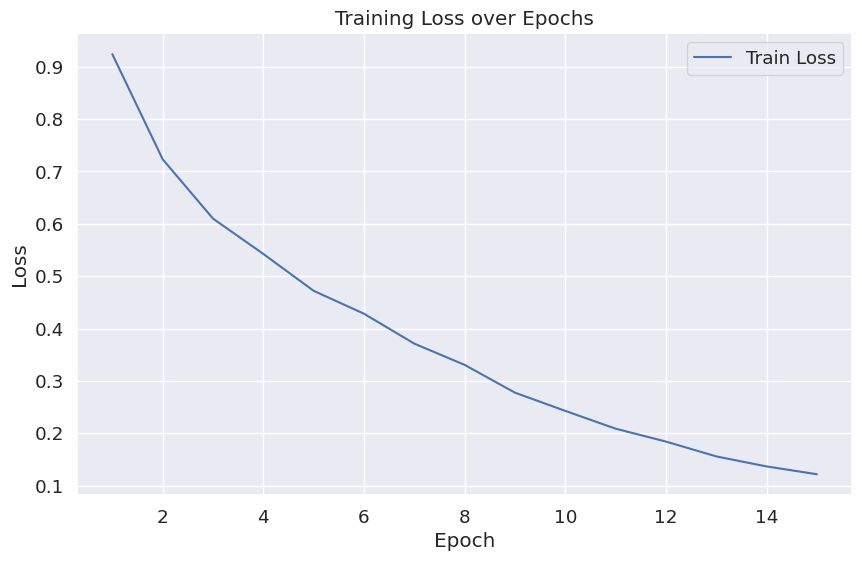

In [79]:
train_model(model, train_dataloader, criterion, optimizer, num_epochs, DEVICE)


In [80]:
y_true = []
y_pred = []

model.eval()

with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader):
        model_input = inputs.to(DEVICE)
        outputs = model(model_input)

        targets = targets.tolist()

        y_true += targets
        y_pred += (torch.argmax(outputs, dim=1).tolist())

# Adjust y_pred to align with the range of y_true (subtract 1 from each element)
y_pred_adjusted = [pred + 1 for pred in y_pred]

y_pred = [x + 1 for x in y_pred]

100%|██████████| 884/884 [00:01<00:00, 764.80it/s]


In [81]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true, y_pred_adjusted))

Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.78      0.77       394
           2       0.38      0.36      0.37       170
           3       0.78      0.77      0.77       320

    accuracy                           0.70       884
   macro avg       0.64      0.64      0.64       884
weighted avg       0.69      0.70      0.69       884



In [82]:
y_train = []
y_train_pred = []

model.eval()

with torch.no_grad():
    for inputs, targets in tqdm(train_dataloader):
        model_input = inputs.to(DEVICE)
        outputs = model(model_input)

        targets = targets.tolist()

        y_train += targets
        y_train_pred += (torch.argmax(outputs, dim=1).tolist())

# Adjust y_pred to align with the range of y_true (subtract 1 from each element)
y_pred_adjusted_train = [pred + 1 for pred in y_train_pred]


100%|██████████| 3527/3527 [00:04<00:00, 768.29it/s]


In [83]:
print("Classification Report:")
print(classification_report(y_train, y_pred_adjusted_train))

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98      1571
           2       0.94      0.91      0.92       680
           3       0.98      0.97      0.98      1276

    accuracy                           0.97      3527
   macro avg       0.96      0.96      0.96      3527
weighted avg       0.97      0.97      0.97      3527



In [84]:
import seaborn as sns

In [85]:
def plot_classification_matrix(y_true, y_pred, labels):
    try:
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.set(font_scale=1.2)
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Classification Matrix')
        plt.show()
    except ValueError as e:
        print(e)

In [86]:
def print_classification_report(y_true, y_pred, labels):
    print(classification_report(y_true, y_pred, target_names=labels))

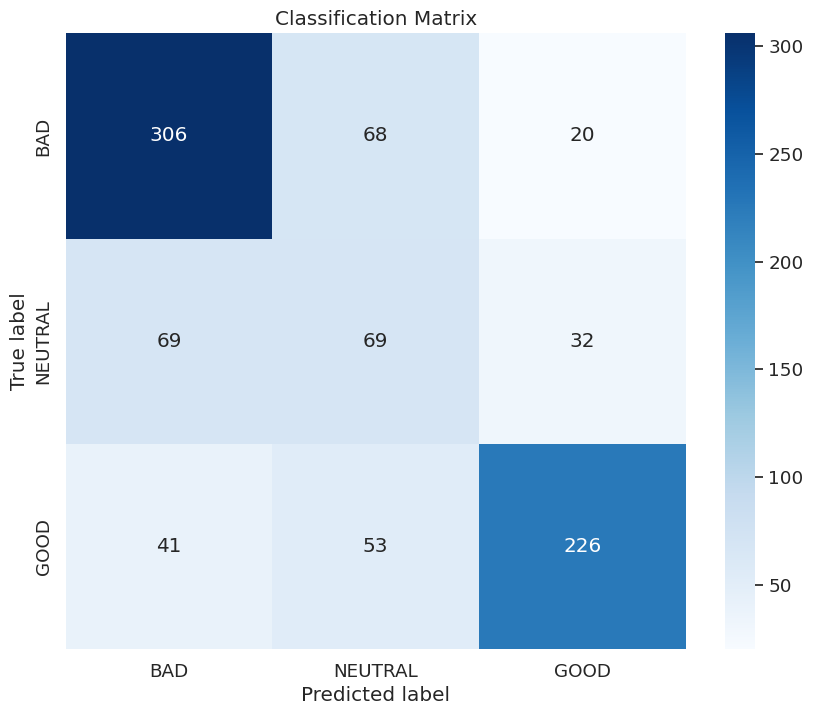

In [70]:

 plot_classification_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'])

In [87]:
print_classification_report(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'])

              precision    recall  f1-score   support

         BAD       0.76      0.78      0.77       394
     NEUTRAL       0.38      0.36      0.37       170
        GOOD       0.78      0.77      0.77       320

    accuracy                           0.70       884
   macro avg       0.64      0.64      0.64       884
weighted avg       0.69      0.70      0.69       884

